## 1. Data reads

In [1]:
%%time

import pandas as pd
import numpy as np
import dask.dataframe as dd

# Use Dask to read large data sets
csv_file_path = 'data_public.csv'
data = dd.read_csv(csv_file_path)

data = data.compute()

# Convert the data into a Parquet file
#parquet_file_path = 'data_tmp.parquet'
#data.to_parquet(parquet_file_path, engine='pyarrow')

# Use Dask to read the Parquet file
#data = dd.read_parquet(parquet_file_path)

# Print the basic information of the data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 239998
Data columns (total 16 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   A       1200000 non-null  float64
 1   B       1200000 non-null  float64
 2   C       1200000 non-null  float64
 3   D       1200000 non-null  float64
 4   E       1200000 non-null  float64
 5   F       1200000 non-null  float64
 6   G       1200000 non-null  float64
 7   H       1200000 non-null  float64
 8   I       1200000 non-null  float64
 9   J       1200000 non-null  float64
 10  K       1200000 non-null  float64
 11  L       1200000 non-null  float64
 12  M       1200000 non-null  float64
 13  N       1200000 non-null  float64
 14  O       1200000 non-null  float64
 15  Class   1200000 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 155.6 MB
None
CPU times: user 3.32 s, sys: 500 ms, total: 3.82 s
Wall time: 1.22 s


In [2]:
# Check the basic information of the data
print(f"The number of rows and columns of the dataset: {data.shape}")
print("data type:")
print(data.dtypes)

# Check for missing values
missing_values = data.isnull().sum()
print("\nThe number of missing values per column:")
print(missing_values)

The number of rows and columns of the dataset: (1200000, 16)
data type:
A        float64
B        float64
C        float64
D        float64
E        float64
F        float64
G        float64
H        float64
I        float64
J        float64
K        float64
L        float64
M        float64
N        float64
O        float64
Class      int64
dtype: object

The number of missing values per column:
A        0
B        0
C        0
D        0
E        0
F        0
G        0
H        0
I        0
J        0
K        0
L        0
M        0
N        0
O        0
Class    0
dtype: int64


## 2. Dataset splitting

### 2.1 Downsample

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt

# The column name of the target variable is 'Class'
target_column = 'Class'

# downsample
class_1 = data[data[target_column] == 1]
class_2 = data[data[target_column] == 2]
class_3 = data[data[target_column] == 3]

n_samples = min(len(class_1), len(class_2), len(class_3))

class_1_downsampled = resample(class_1, replace=False, n_samples=n_samples, random_state=42)
class_2_downsampled = resample(class_2, replace=False, n_samples=n_samples, random_state=42)
class_3_downsampled = resample(class_3, replace=False, n_samples=n_samples, random_state=42)


data_downsampled = pd.concat([class_1_downsampled, class_2_downsampled, class_3_downsampled])


downsampled_class_counts = data_downsampled[target_column].value_counts()
print("Downsampled class distribution:\n", downsampled_class_counts)

Downsampled class distribution:
 Class
1    180594
2    180594
3    180594
Name: count, dtype: int64


### 2.2 Divide the training set and the test set

In [4]:
# Separate features and target variables
X = data_downsampled.drop(target_column, axis=1)
y = data_downsampled[target_column]

# Standardized features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Merge X and Y
data_combined = pd.concat([pd.DataFrame(X_scaled, columns=X.columns), y.reset_index(drop=True)], axis=1)

# The current setup is about 12,000 for a smaller sample
#data_combined = data_combined.sample(frac=0.8, random_state=42)

# Separate the feature and target variables again
X_sampled = data_combined.drop(columns=target_column)
y_sampled = data_combined[target_column]

X_sampled_np = X_sampled.to_numpy()

# From a small sample data set, divide the training set and the test set
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.3, random_state=42)

X_train

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
209228,-0.592167,0.599974,-0.503003,0.784903,-0.757562,-0.025119,-0.347950,-0.784764,-1.083694,-0.132736,-0.872268,0.575452,-0.764209,-0.842011,-1.056506
73817,-0.838265,-1.273971,-1.018471,-1.660036,-0.585705,-1.362917,-1.166090,-0.615859,0.293979,-1.507276,-0.347639,-1.908776,-0.561570,-0.334415,-0.129607
346419,-0.588759,0.696863,-0.531051,0.819734,-0.766170,-0.177904,-0.402611,-0.787858,-1.178830,-0.056012,-0.938640,0.786253,-0.800674,-0.844205,-0.941463
41610,1.430370,0.604929,1.309735,0.219589,1.421846,0.994948,1.295440,1.544682,1.191849,1.263305,1.548284,0.530959,1.527187,1.280197,1.393889
483662,-0.630517,0.576640,-0.495487,0.887435,-0.692603,-0.108834,-0.421589,-0.759113,-1.129649,-0.048056,-0.908947,1.124893,-0.797001,-0.933601,-1.058539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17610,-0.864788,-1.273498,-1.044574,-1.635635,-0.563507,-1.308533,-1.178470,-0.630617,0.286867,-1.549412,-0.445146,-1.581981,-0.148081,-0.300662,-0.135041
384099,-0.676303,0.315837,-0.524427,0.766315,-0.719989,-0.118464,-0.411661,-0.769420,-1.267439,-0.096122,-0.850610,0.496842,-0.663552,-0.904076,-0.971849
77429,-0.835250,-0.824103,-1.046684,-1.560633,-0.631314,-1.508925,-1.108743,-0.491858,0.252303,-1.521996,-0.417613,-1.650973,-0.632417,-0.433009,-0.028571
125431,1.392349,0.977884,1.344345,0.150732,1.392004,1.386027,1.408324,1.512830,1.158654,1.151111,1.468693,0.475990,1.504247,1.387742,1.472212


## 3. Feature analysis

### 3.1 Pearson correlation coefficient characteristic analysis

Pearson correlation coefficient between features:
              A         B         C         D         E         F         G  \
A      1.000000  0.527472  0.991397  0.214878  0.989134  0.904815  0.970670   
B      0.527472  1.000000  0.614108  0.895220  0.417233  0.812693  0.689284   
C      0.991397  0.614108  1.000000  0.323076  0.967370  0.945406  0.988599   
D      0.214878  0.895220  0.323076  1.000000  0.085004  0.601076  0.423275   
E      0.989134  0.417233  0.967370  0.085004  1.000000  0.841620  0.932716   
F      0.904815  0.812693  0.945406  0.601076  0.841620  1.000000  0.971429   
G      0.970670  0.689284  0.988599  0.423275  0.932716  0.971429  1.000000   
H      0.986744  0.402503  0.963111  0.068148  0.996963  0.832468  0.926723   
I      0.758927 -0.113152  0.681423 -0.460806  0.835935  0.420553  0.596816   
J      0.872404  0.847377  0.920483  0.656992  0.801041  0.991483  0.954128   
K      0.961348  0.297330  0.925020 -0.048694  0.986823  0.761776  0.876869   
L 

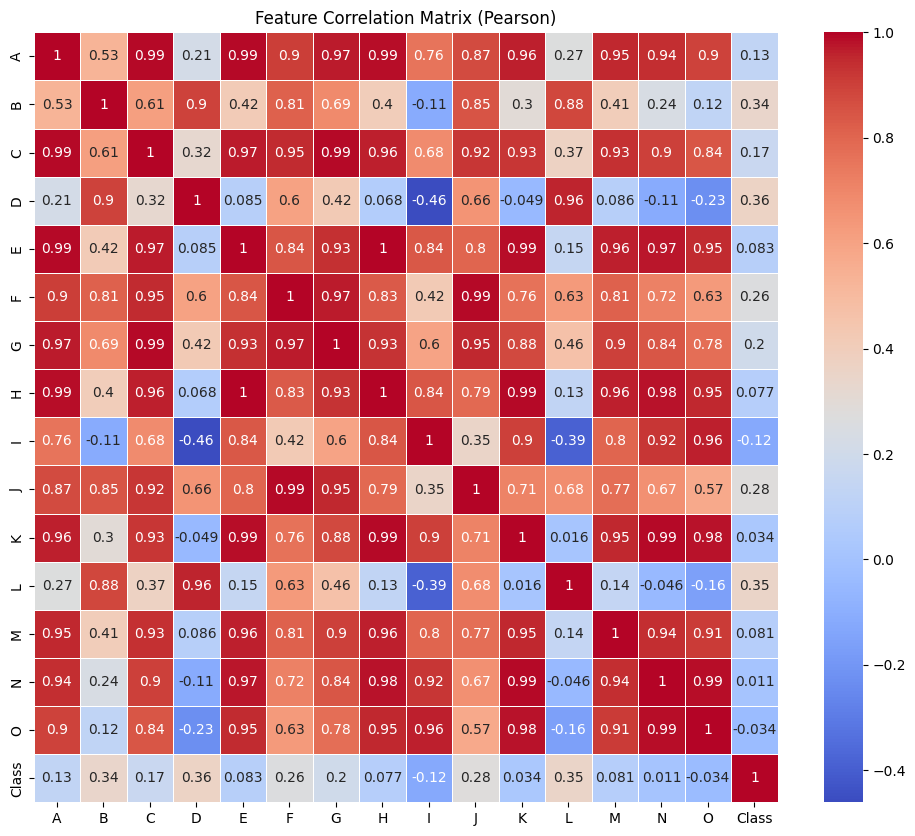

CPU times: user 707 ms, sys: 21.8 ms, total: 729 ms
Wall time: 372 ms


In [5]:
%%time

import matplotlib.pyplot as plt
import seaborn as sns

# The Pearson correlation coefficient between features is calculated
correlation_matrix = data_combined.corr()

# Print the correlation coefficient matrix
print("Pearson correlation coefficient between features:")
print(correlation_matrix)

# Visualize the correlation coefficient matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix (Pearson)')
plt.show()

### 3.2 PCA dimensionality reduction

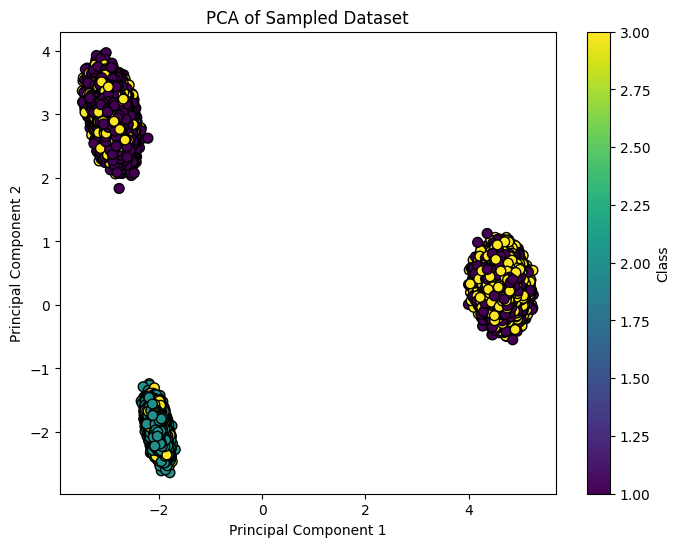

CPU times: user 7.69 s, sys: 3.2 s, total: 10.9 s
Wall time: 4.01 s


In [6]:
%%time 

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# # Feature engineering: PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sampled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sampled, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Sampled Dataset')
plt.colorbar(label='Class')
plt.show()

### 3.3 Mini MiniBatch K-means cluster analysis

/Users/eric/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


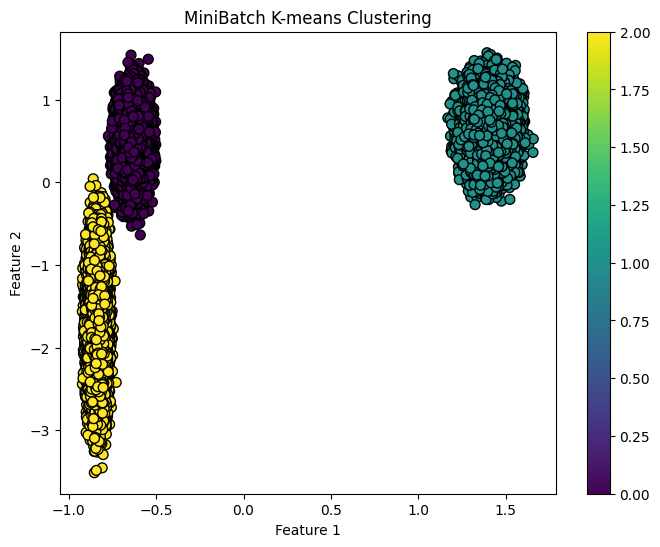

CPU times: user 6.34 s, sys: 3.91 s, total: 10.3 s
Wall time: 4.12 s


In [7]:
%%time

from sklearn.cluster import MiniBatchKMeans

#  MiniBatch K-means
minibatch_kmeans = MiniBatchKMeans(n_clusters=3, batch_size=10000, random_state=42)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(X_sampled)

# Visualize clustering results
plt.figure(figsize=(8, 6))
plt.scatter(X_sampled.to_numpy()[:, 0], X_sampled.to_numpy()[:, 1], c=minibatch_kmeans_labels, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('MiniBatch K-means Clustering')
plt.colorbar()
plt.show()

## 4. Model training

### 4.1 Define the model pipeline and use random forests for supervised learning

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Build Scikit-Learn Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Define the pipeline for data preprocessing
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

# Create a ColumnTransformer to apply to all feature columns
column_transformer = ColumnTransformer(transformers=[
    ('num', preprocessor, X.columns)
])

# Define the model pipeline and n_jobs=-1 for parallelism
classifier = RandomForestClassifier(n_jobs=-1)
pipeline = Pipeline([
    ('preprocessor', column_transformer),
    ('classifier', classifier)
])

### 4.2 Training the model

In [9]:
%%time

# Train the model
pipeline.fit(X_train, y_train)

CPU times: user 1min 53s, sys: 2.98 s, total: 1min 56s
Wall time: 13.4 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(n_jobs=-1))])

### 4.3 Use GridSearchCV to tune parameters

In [10]:
%%time

from sklearn.model_selection import GridSearchCV

# Evaluate the model on the test set
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [4, 5, 6, 7, 8],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters found: {'classifier__criterion': 'entropy', 'classifier__max_depth': 7, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}
Best cross-validation score: 0.7051562682594292
CPU times: user 32.7 s, sys: 3.41 s, total: 36.1 s
Wall time: 10min 57s


In [11]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


y_pred = grid_search.predict(X_test)
print("Test set evaluation:")
print(classification_report(y_test, y_pred))

Test set evaluation:
              precision    recall  f1-score   support

           1       0.76      0.56      0.64     43347
           2       0.79      1.00      0.88     43451
           3       0.56      0.56      0.56     43230

    accuracy                           0.71    130028
   macro avg       0.70      0.71      0.70    130028
weighted avg       0.70      0.71      0.70    130028

CPU times: user 2.03 s, sys: 305 ms, total: 2.33 s
Wall time: 343 ms


### 4.4 Training more model

In [12]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

def train_model(model, X_train, y_train):
    pipeline = Pipeline([
        ('preprocessor', column_transformer),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    return pipeline


# Define a classifier
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
}

trained_models = {}
for name, model in models.items():
    trained_models[name] = train_model(model, X_train, y_train)

CPU times: user 4.36 s, sys: 391 ms, total: 4.75 s
Wall time: 653 ms


### 4.5 Evaluation models

In [13]:
%%time

from sklearn.metrics import classification_report

def evaluate_model(trained_model, X_test, y_test):
    y_pred = trained_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return report

# Evaluate all trained models
evaluation_results = {}
for name, trained_model in trained_models.items():
    evaluation_results[name] = evaluate_model(trained_model, X_test, y_test)

# output result
for model_name, metrics in evaluation_results.items():
    print(f"Model: {model_name}")
    print(classification_report(y_test, trained_models[model_name].predict(X_test), target_names=['class 1', 'class 2', 'class 3']))


Model: KNN
              precision    recall  f1-score   support

     class 1       0.64      0.68      0.66     43347
     class 2       0.79      0.93      0.86     43451
     class 3       0.49      0.37      0.42     43230

    accuracy                           0.66    130028
   macro avg       0.64      0.66      0.65    130028
weighted avg       0.64      0.66      0.65    130028

CPU times: user 6.01 s, sys: 1.42 s, total: 7.43 s
Wall time: 3.22 s


## 5. Models are saved and converted to ONNX format

In [14]:
%%time 

import onnx
import onnxruntime as rt
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Save the best model in ONNX format
best_model = grid_search.best_estimator_
input_types = [(x, FloatTensorType([None, 1])) for x in X.columns]
onnx_model = convert_sklearn(best_model, initial_types=input_types)

onnx_model_path = "pipeline_model.onnx"
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

CPU times: user 273 ms, sys: 31.2 ms, total: 304 ms
Wall time: 332 ms


## 6. Inference using the ONNX model

### 6.1 Inference perform

In [16]:
# Load the ONNX model and make predictions

import pandas as pd
import numpy as np
import onnx
import onnxruntime as rt
from sklearn.metrics import classification_report
import dask.dataframe as dd

# Read the CSV file
csv_file_path = 'data_public.csv'
data = dd.read_csv(csv_file_path)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# The column name of the target variable is 'Class'
target_column = 'Class'

# Separate features and target variables
X = data.drop(columns=target_column)
y = data[target_column]

# Convert Dasco Datafram to Pandas Datafram
X = X.compute()
y = y.compute()

# Standardized features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Because the dataset is relatively large, a part of the dataset is collected for analysis

# Merge X and Y
data_combined = pd.concat([pd.DataFrame(X_scaled, columns=X.columns), y.reset_index(drop=True)], axis=1)

data_sampled = data_combined

# Separate the feature and target variables again
X_sampled = data_sampled.drop(columns=target_column)
y_sampled = data_sampled[target_column]

X_sampled_np = X_sampled.to_numpy()

# From a small sample data set, divide the training set and the test set
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sampled, y_sampled, test_size=0.3, random_state=42)

onnx_model_path = "pipeline_model.onnx"
inputs_onnx = {k: np.array(v).astype(np.float32).reshape(-1, 1) for k, v in X_test_sample.to_dict(orient='list').items()}
session_onnx = rt.InferenceSession(onnx_model_path)
predict_onnx = session_onnx.run(None, inputs_onnx)
print("ONNX Model Prediction Result:", predict_onnx[0])

# The ONNX prediction results were compared to the actual test set labels
print("\nONNX Model Prediction Report:")
print(classification_report(y_test_sample, predict_onnx[0]))

ONNX Model Prediction Result: [1 1 3 ... 2 2 2]

ONNX Model Prediction Report:
              precision    recall  f1-score   support

           1       0.50      0.56      0.53     54202
           2       0.75      0.96      0.84    134934
           3       0.77      0.57      0.65    170864

    accuracy                           0.71    360000
   macro avg       0.67      0.70      0.67    360000
weighted avg       0.72      0.71      0.71    360000

